## Model Parallelism and Pipeline Parallelism:

A type of model parallelism which specific model weights, gradients and optimizer states are split across devices. In contrast to pipeline parallelism, which keeps individual weights intact but partitions the set of weights, tensor parallelism splits individual weights. 

References:

https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/7fb7efcebd169edefbbd6ea08aab1bc7/pipeline_tutorial.ipynb

https://docs.aws.amazon.com/sagemaker/latest/dg/model-parallel-extended-features-pytorch-tensor-parallelism-examples.html

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

https://pytorch.org/tutorials/intermediate/model_parallel_tutorial.html



In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import sys
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD
import numpy as np

In [19]:
if torch.cuda.device_count() < 2:
    print('Need at least two GPU devices for this tutorial')
    sys.exit(0)

In [ ]:
device = torch.device('cuda:0')

We first will load the training data CIFAR-10:

In [ ]:
import torchvision 
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We will train CIFAR-10 with a ResNet50 Model. 

In [ ]:
from torchvision.models.resnet import ResNet, Bottleneck

num_classes = 10


class ModelParallelResNet50(ResNet):
    def __init__(self, *args, **kwargs):
        super(ModelParallelResNet50, self).__init__(
            Bottleneck, [3, 4, 6, 3], num_classes=num_classes, *args, **kwargs)

        self.seq1 = nn.Sequential(
            self.conv1,
            self.bn1,
            self.relu,
            self.maxpool,

            self.layer1,
            self.layer2
        ).to('cuda:0')

        self.seq2 = nn.Sequential(
            self.layer3,
            self.layer4,
            self.avgpool,
        ).to('cuda:1')

        self.fc.to('cuda:1')

    def forward(self, x):
        x = self.seq2(self.seq1(x).to('cuda:1'))
        return self.fc(x.view(x.size(0), -1))

We first will do a experiment to see how the model parallelism perform in a small batch of randomly generated inputs and labels:

In [ ]:
import torchvision.models as models

num_batches = 3
batch_size = 120
image_w = 128
image_h = 128


def train(model):
    model.train(True)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    one_hot_indices = torch.LongTensor(batch_size) \
                           .random_(0, num_classes) \
                           .view(batch_size, 1)

    for _ in range(num_batches):
        # generate random inputs and labels
        inputs = torch.randn(batch_size, 3, image_w, image_h)
        labels = torch.zeros(batch_size, num_classes) \
                      .scatter_(1, one_hot_indices, 1)

        # run forward pass
        optimizer.zero_grad()
        outputs = model(inputs.to('cuda:0'))

        # run backward pass
        labels = labels.to(outputs.device)
        loss_fn(outputs, labels).backward()
        optimizer.step()

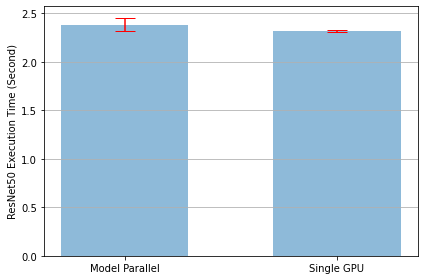

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()


plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

We can see that Model Parallelism in this stage does not have any advantages. We can see the execution time for Model Parallel is even longer compare to Single GPU. 

Then for the next experiment, we want to see when will model parallelism have advantages. We are now using CIFAR-10 instead of randomly generated inputs and labels that have much smaller size. 

In [ ]:
import torchvision.models as models

def train(model):
    model.train(True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs.to('cuda:0'))
          labels = labels.to(outputs.device)
          loss = criterion(outputs, labels.view(labels.size(0),-1).float())
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

    print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1,  2000] loss: 15.911
[1,  4000] loss: 12.325
[1,  6000] loss: 11.136
[1,  8000] loss: 10.108
[1, 10000] loss: 9.773
[1, 12000] loss: 9.091
[2,  2000] loss: 9.067
[2,  4000] loss: 8.666
[2,  6000] loss: 8.937
[2,  8000] loss: 9.032
[2, 10000] loss: 8.651
[2, 12000] loss: 8.604
Finished Training
[1,  2000] loss: 17.223
[1,  4000] loss: 11.818
[1,  6000] loss: 10.516
[1,  8000] loss: 10.421
[1, 10000] loss: 9.671
[1, 12000] loss: 8.964
[2,  2000] loss: 9.048
[2,  4000] loss: 8.760
[2,  6000] loss: 8.593
[2,  8000] loss: 8.572
[2, 10000] loss: 8.604
[2, 12000] loss: 8.469
Finished Training
[1,  2000] loss: 16.307
[1,  4000] loss: 11.397
[1,  6000] loss: 10.484
[1,  8000] loss: 9.475
[1, 10000] loss: 9.550
[1, 12000] loss: 9.109
[2,  2000] loss: 8.658
[2,  4000] loss: 8.823
[2,  6000] loss: 8.680
[2,  8000] loss: 8.736
[2, 10000] loss: 8.584
[2, 12000] loss: 8.742
Finished Training
[1,  2000] loss: 16.541
[1,  4000] loss: 11.625
[1,  6000] loss: 10.636
[1,  8000] loss: 9.914
[1, 10000] l

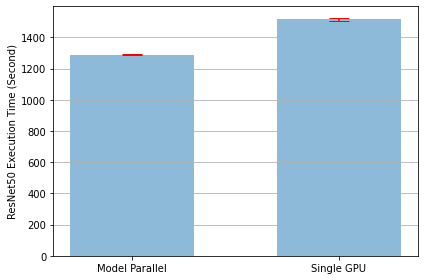

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import timeit

num_repeat = 10

stmt = "train(model)"

setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)


def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

plot([mp_mean, rn_mean],
     [mp_std, rn_std],
     ['Model Parallel', 'Single GPU'],
     'mp_vs_rn.png')

For the next experiment, we will add the pipeline parallelism on top of the original model parallelism spliting layers onto different GPU. We will first define the model as below and test it on the original randomly generated inputs and labels and split up the 120-image batch into 20-image splits.

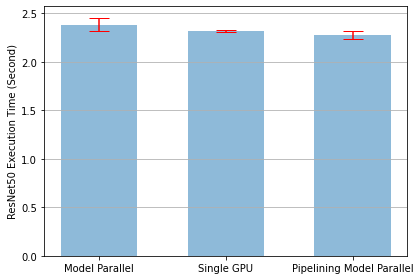

In [ ]:
class PipelineParallelResNet50(ModelParallelResNet50):
    def __init__(self, split_size=20, *args, **kwargs):
        super(PipelineParallelResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1')
        ret = []

        for s_next in splits:
            # A. s_prev runs on cuda:1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:0, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:1')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)


setup = "model = PipelineParallelResNet50()"
pp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
pp_mean, pp_std = np.mean(pp_run_times), np.std(pp_run_times)

plot([mp_mean, rn_mean, pp_mean],
     [mp_std, rn_std, pp_std],
     ['Model Parallel', 'Single GPU', 'Pipelining Model Parallel'],
     'mp_vs_rn_vs_pp.png')

We then create the experiments again with the CIFAR-10:

In [ ]:
setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)

setup = "model = PipelineParallelResNet50()"
pp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
pp_mean, pp_std = np.mean(pp_run_times), np.std(pp_run_times)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([120, 1])) that is different to the input size (torch.Size([120, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([80, 1])) that is different to the input size (torch.Size([80, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


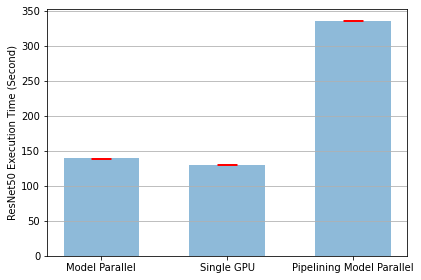

In [ ]:
plot([mp_mean, rn_mean, pp_mean],
     [mp_std, rn_std, pp_std],
     ['Model Parallel', 'Single GPU', 'Pipelining Model Parallel'],
     'mp_vs_rn_vs_pp.png')

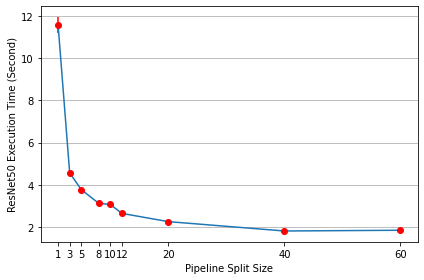

In [ ]:
import timeit
stmt = "train(model)"
num_repeat = 10
means = []
stds = []
split_sizes = [1, 3, 5, 8, 10, 12, 20, 40, 60]

for split_size in split_sizes:
    setup = "model = PipelineParallelResNet50(split_size=%d)" % split_size
    pp_run_times = timeit.repeat(
        stmt, setup, number=1, repeat=num_repeat, globals=globals())
    means.append(np.mean(pp_run_times))
    stds.append(np.std(pp_run_times))

fig, ax = plt.subplots()
ax.plot(split_sizes, means)
ax.errorbar(split_sizes, means, yerr=stds, ecolor='red', fmt='ro')
ax.set_ylabel('ResNet50 Execution Time (Second)')
ax.set_xlabel('Pipeline Split Size')
ax.set_xticks(split_sizes)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
class PipelineParallelResNet50(ModelParallelResNet50):
    def __init__(self, split_size=8, *args, **kwargs):
        super(PipelineParallelResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1')
        ret = []

        for s_next in splits:
            # A. s_prev runs on cuda:1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:0, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:1')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)

setup = "model = ModelParallelResNet50()"
mp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
mp_mean, mp_std = np.mean(mp_run_times), np.std(mp_run_times)

setup = "import torchvision.models as models;" + \
        "model = models.resnet50(num_classes=num_classes).to('cuda:0')"
rn_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
rn_mean, rn_std = np.mean(rn_run_times), np.std(rn_run_times)

setup = "model = PipelineParallelResNet50()"
pp_run_times = timeit.repeat(
    stmt, setup, number=1, repeat=num_repeat, globals=globals())
pp_mean, pp_std = np.mean(pp_run_times), np.std(pp_run_times)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


In [ ]:
def plot(means, stds, labels, fig_name):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(means)), means, yerr=stds,
           align='center', alpha=0.5, ecolor='red', capsize=10, width=0.6)
    ax.set_ylabel('ResNet50 Execution Time (Second)')
    ax.set_xticks(np.arange(len(means)))
    ax.set_xticklabels(labels)
    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

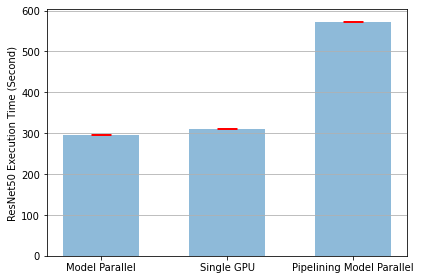

In [ ]:
plot([mp_mean, rn_mean, pp_mean],
     [mp_std, rn_std, pp_std],
     ['Model Parallel', 'Single GPU', 'Pipelining Model Parallel'],
     'mp_vs_rn_vs_pp.png')

In [21]:
class PipelineParallelResNet50(ModelParallelResNet50):
    def __init__(self, split_size=20, *args, **kwargs):
        super(PipelineParallelResNet50, self).__init__(*args, **kwargs)
        self.split_size = split_size

    def forward(self, x):
        splits = iter(x.split(self.split_size, dim=0))
        s_next = next(splits)
        s_prev = self.seq1(s_next).to('cuda:1')
        ret = []

        for s_next in splits:
            # A. s_prev runs on cuda:1
            s_prev = self.seq2(s_prev)
            ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

            # B. s_next runs on cuda:0, which can run concurrently with A
            s_prev = self.seq1(s_next).to('cuda:1')

        s_prev = self.seq2(s_prev)
        ret.append(self.fc(s_prev.view(s_prev.size(0), -1)))

        return torch.cat(ret)

In [ ]:
import timeit
stmt = "train(model)"
num_repeat = 10
means = []
stds = []
split_sizes = [1, 4, 8, 16]

for split_size in split_sizes:
    setup = "model = PipelineParallelResNet50(split_size=%d)" % split_size
    pp_run_times = timeit.repeat(
        stmt, setup, number=1, repeat=num_repeat, globals=globals())
    means.append(np.mean(pp_run_times))
    stds.append(np.std(pp_run_times))

fig, ax = plt.subplots()
ax.plot(split_sizes, means)
ax.errorbar(split_sizes, means, yerr=stds, ecolor='red', fmt='ro')
ax.set_ylabel('ResNet50 Execution Time (Second)')
ax.set_xlabel('Pipeline Split Size')
ax.set_xticks(split_sizes)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()